In [1]:
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)


import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour, TomekLinks

#### 1 Under- vs. Over-sampling

In [2]:
from sklearn.datasets import fetch_openml
from collections import Counter

credit = fetch_openml('credit-g', parser='auto', version=1)
features = credit.data
target = credit.target

print('Original dataset shape %s' % Counter(target))


Original dataset shape Counter({'good': 700, 'bad': 300})


#### 1.1 Feature engineering (10pt)

In [3]:
def encode_data(features: pd.DataFrame) -> pd.DataFrame:
    # Identify numeric and categorical columns
    numeric_columns = features.select_dtypes(include='number').columns
    categorical_columns = features.select_dtypes(exclude='number').columns

    # Leave numeric columns as is
    numeric_data = features[numeric_columns]

    # One-hot encode categorical columns
    categorical_data = pd.get_dummies(features[categorical_columns])

    # Concatenate numeric and one-hot encoded categorical data
    encoded_data = pd.concat([numeric_data, categorical_data], axis=1)

    return encoded_data

x = encode_data(features)
features.shape, x.shape


((1000, 20), (1000, 61))

In [4]:
def encode_target(target: np.array) -> np.array:
    # Assuming 'bad' is mapped to 0 and 'good' is mapped to 1
    encoded_target = np.where(target == 'bad', 0, 1)
    return encoded_target

y = encode_target(target)
print('Original dataset shape %s' % Counter(y))


Original dataset shape Counter({1: 700, 0: 300})


In [5]:
x_train, x_test, y_train, y_test = train_test_split(
   x, y, shuffle=True, random_state=13, test_size=0.2, stratify=y
)

#### 1.2 Create a function called cnn_cv (10pts)

In [6]:
def cnn_cv(x: np.array, y: np.array, n_neighbors: int = 3, folds: int = 3) -> tuple:
    predicted = []
    actual = []

    kf = StratifiedKFold(n_splits=folds)
    kf.get_n_splits(x, y)

    for i, (train_index, val_index) in enumerate(kf.split(x, y)):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Scale using training data.
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_val = scaler.transform(x_val)

        # Undersample with CondensedNearestNeighbour.
        cnn = CondensedNearestNeighbour(random_state = i, n_neighbors=n_neighbors)
        x_train, y_train = cnn.fit_resample(x_train, y_train)

        # Train LR.
        lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)

        # Predict on validation set.
        predicted.append(lr.predict_proba(x_val)[:, 1])
        actual.append(y_val)

    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    precision, recall, _ = precision_recall_curve(actual, predicted)

    aucpr = auc(recall, precision)
    aucroc = roc_auc_score(actual, predicted)

    return aucpr, aucroc

In [7]:
def smote_cv(x, y, folds: int = 3, sampling_strategy: float = 0.5) -> tuple:
  predicted = []
  actual = []

  kf = StratifiedKFold(n_splits = folds)
  kf.get_n_splits(x, y)

  for i, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Scale using training data.
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # Oversample with SMOTE.
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=i)
    x_train, y_train = smote.fit_resample(x_train, y_train)

    # Train LR.
    lr = LogisticRegression(max_iter = 1000).fit(x_train, y_train)

    # Predict on validation set.
    predicted.append(lr.predict_proba(x_val)[:, 1])
    actual.append(y_val)

  actual = np.concatenate(actual)
  predicted = np.concatenate(predicted)
  precision, recall, _ = precision_recall_curve(actual, predicted)

  aucpr = auc(recall, precision)
  aucroc = roc_auc_score(actual, predicted)

  return aucpr, aucroc

#### 1.3 Determine the best under- and over-sampling hyperparameters (20pts)

In [8]:
n_neighbors = [1, 2, 3, 4, 5]
sampling_strategy = [0.5, 0.6, 0.7, 0.8, 0.9]

print('N neighbors')
for n in n_neighbors:
    pr, roc = cnn_cv(x=x_train.values, y=y_train, n_neighbors=n)
    print(f'{n} neighbors: pr-{round(pr,3)} roc-{round(roc,3)}')

print()
print('Sampling_strategy')
for s in sampling_strategy:
    pr, roc = smote_cv(x=x_train.values, y=y_train, folds=3, sampling_strategy=s)
    print(f'{s}: pr-{round(pr,3)} roc-{round(roc,3)}')

N neighbors
1 neighbors: pr-0.844 roc-0.729
2 neighbors: pr-0.859 roc-0.744
3 neighbors: pr-0.855 roc-0.737
4 neighbors: pr-0.854 roc-0.74
5 neighbors: pr-0.856 roc-0.743

Sampling_strategy
0.5: pr-0.864 roc-0.752
0.6: pr-0.86 roc-0.749
0.7: pr-0.862 roc-0.752
0.8: pr-0.857 roc-0.745
0.9: pr-0.858 roc-0.747


For n neighbors, the best parameter is n=2 with pr-0.859 roc-0.744.

For Sampling strategy, the best parameter is 0.5 with pr-0.864 roc-0.752

#### 1.4 Use your hyperparameters on test data (10pts)

Train a Logistic Regression model using the following data:
- x_train, y_train
- x_train_cnn, y_train_cnn (undersample using your best n_neighbors from 1.3)
- x_train_smote, y_train_smote (oversample using your best sampling_strategy from 1.3)

Report the AUCPR/AUCROC on x_test, y_test from the three trained models. What are your conclusions on under- and over-sampling for this dataset?

In [9]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:
# x_train, y_train
lr = LogisticRegression(max_iter = 1000)
lr.fit(x_train, y_train)
y_hat_test = lr.predict_proba(x_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
aucpr = auc(recall, precision)
aucroc = roc_auc_score(y_test, y_hat_test)
print('No sampling: aucpr = %.3f; aucroc = %.3f' % (aucpr, aucroc))

No sampling: aucpr = 0.914; aucroc = 0.823


In [11]:
# x_train_cnn, y_train_cnn
cnn = CondensedNearestNeighbour(random_state = 13, n_neighbors=2)
x_train_cnn, y_train_cnn = cnn.fit_resample(x_train, y_train)

lr = LogisticRegression(max_iter = 1000)
lr.fit(x_train_cnn, y_train_cnn)
y_hat_test = lr.predict_proba(x_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
aucpr = auc(recall, precision)
aucroc = roc_auc_score(y_test, y_hat_test)
print('Under-sampling: aucpr = %.3f; aucroc = %.3f' % (aucpr, aucroc))

Under-sampling: aucpr = 0.904; aucroc = 0.788


In [12]:
# x_train_smote, y_train_smote
smote = SMOTE(random_state = 13, sampling_strategy=0.5)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

lr = LogisticRegression(max_iter = 1000)
lr.fit(x_train_smote, y_train_smote)
y_hat_test = lr.predict_proba(x_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
aucpr = auc(recall, precision)
aucroc = roc_auc_score(y_test, y_hat_test)
print('Over-sampling: aucpr = %.3f; aucroc = %.3f' % (aucpr, aucroc))

Over-sampling: aucpr = 0.912; aucroc = 0.817


- No sampling: aucpr = 0.914; aucroc = 0.823
- Under-sampling: aucpr = 0.904; aucroc = 0.788
- Over-sampling: aucpr = 0.912; aucroc = 0.817

When we under-sampling the data, the aucpr and aucroc are both lower than no sampling.

When we over-sampling, the aucpr and aucroc are lower but close with no-sampling.

#### 2.1 Intuition (5 pts)

Intuitively, how do you expect the bias and variance to behave for small values of m? What about large values of m?

Ans: 
When the m is small, I expect the bias is going to be high and variance is low. 

When the m is large, I expect the bias is going to be lower and variance is higher. 

#### 2.2 Write a function to simulate 𝒇(x) (5 pts)

In [13]:
def generate_fx(n: int, sigma: float = 1) -> np.array:
    np.random.seed(13)
    
    # Create equally spaced values of x.
    x = np.linspace(1/n, 1, num=n)
    
    # Determine the true f(x).
    fx = 4 * np.sin(np.pi * x) * np.cos(6 * np.pi * x**2)
    
    # Add Gaussian noise N(0, sigma).
    eps = np.random.normal(0, sigma, size=n)
    y = fx + eps
    
    return x, y

#### 2.3 Write a function to estimate 𝒇(x) (5 pts)

In [14]:
def fhat(x: np.array, y: np.array, m: int) -> pd.DataFrame:
    # Calculate the number of data points in each segment
    segment_size = len(x) // m

    # Initialize lists to store results
    y_hat = []

    # Iterate over segments
    for i in range(m):
        # Determine the start and end indices for the current segment
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size if i < m - 1 else len(x)

        # Calculate the average of y values in the current segment
        avg_y = np.mean(y[start_idx:end_idx])
        y_list = [avg_y] * segment_size
        # Append the midpoint of the segment and the average y value to the results
        y_hat += y_list
    
    return pd.DataFrame({'x': x, 'yhat': y_hat})

Using n=256, m=16 and σ =1.0, recreate the plot above. Use random_state=13 to simulate data.

In [15]:
x, y = generate_fx(n=256, sigma=1)
data = fhat(x, y, m=16)

In [16]:
n = 256
x_line = np.linspace(1/n, 1, num=n)
y_line = 4 * np.sin(np.pi * x) * np.cos(6 * np.pi * x**2)

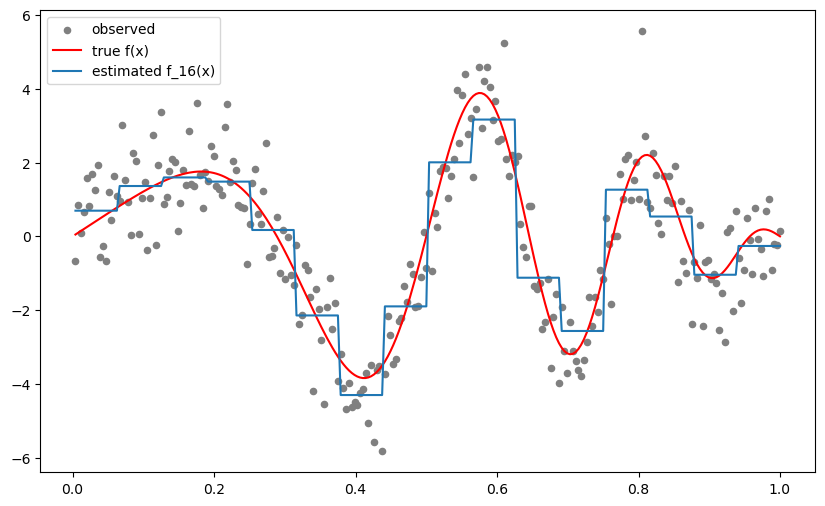

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='observed', color='grey', s=20)
plt.plot(x_line, y_line, label='true f(x)', color='red')
plt.plot(data['x'], data['yhat'], label='estimated f_16(x)')
plt.legend()

#### 2.4 Average bias-squared (5 pts) 

To prove the given equality, let's break down each side of the equation:

**Left-hand side (LHS):**


$\frac{1}{n} \sum_{i=1}^n\left(E\left[\hat{f}_m\left(x_i\right)\right]-f\left(x_i\right)\right)^2$


This expression involves the expected value of the function \(\hat{f}_m(x_i)\) and the true function \(f(x_i)\) for each data point \(x_i\). The expected value is taken over the random variable \(\hat{f}_m(x_i)\). The square of the difference between these two functions is then averaged over all data points.

**Right-hand side (RHS):**


$\frac{1}{n} \sum_{j=1}^{n / m} \sum_{i=(j-1) m+1}^{j m}\left(\bar{f}^{(j)}-f\left(x_i\right)\right)^2$


Here, the data points are grouped into blocks of size \(m\), and for each block \(j\), \(\bar{f}^{(j)}\) represents the average of the function \(\hat{f}_m(x_i)\) over that block. The square of the difference between this block average and the true function \(f(x_i)\) is then averaged over all blocks.

Now, let's see how these two expressions are related. The key is to recognize that the term \(\bar{f}^{(j)}\) is an average over a block of size \(m\), and this is related to the expected value in the LHS. We can express \(\bar{f}^{(j)}\) in terms of the expected value:


$\bar{f}^{(j)} = \frac{1}{m} \sum_{i=(j-1)m+1}^{jm} \hat{f}_m(x_i)$


Now, consider the square of the difference:


$\left(\bar{f}^{(j)} - f(x_i)\right)^2 = \left(\frac{1}{m} \sum_{i=(j-1)m+1}^{jm} \hat{f}_m(x_i) - f(x_i)\right)^2$


Take the expected value of this expression:


$E\left[\left(\bar{f}^{(j)} - f(x_i)\right)^2\right]$

This expectation is over the random variable \(\hat{f}_m(x_i)\) within the block. Now, average this over all blocks:

$\frac{1}{n/m} \sum_{j=1}^{n/m} E\left[\left(\bar{f}^{(j)} - f(x_i)\right)^2\right]$


This is almost the RHS, but we have \(n/m\) in the denominator instead of \(n\). To fix this, multiply and divide by \(m\):


$\frac{1}{n} \sum_{j=1}^{n/m} m \cdot E\left[\left(\bar{f}^{(j)} - f(x_i)\right)^2\right]$

Now, substitute \(\bar{f}^{(j)}\) from its definition:


$\frac{1}{n} \sum_{j=1}^{n/m} \sum_{i=(j-1)m+1}^{jm} E\left[\left(\hat{f}_m(x_i) - f(x_i)\right)^2\right]$


This is equivalent to the RHS. Therefore, the given equality holds.


In [18]:
def f_bar(x: np.array, y: np.array, j: int, m: int) -> float:
    i = np.arange((j-1)*m, j*m, dtype=int)
    return np.mean(y[i])

In [19]:
def avg_bias_squared(x: np.array, y: np.array, m: int, n: int = 256) -> float:
    bias_sq = 0
    for j in np.arange(1, n / m + 1, dtype=int):
        i = np.arange((j-1)*m, j*m, dtype=int)
        bias_sq += np.sum((f_bar(x, y, j, m) - y[i])**2)
    return bias_sq / n

#### 2.5 Average variance (5 pts)

Given equality:

$$
\text{1. **Left-hand side (LHS):}$$
$$
E\left[\frac{1}{n} \sum_{i=1}^n\left(\hat{f}\left(x_i\right)-E\left[\hat{f}\left(x_i\right)\right]\right)^2\right]
$$

This represents the expected value of the sample variance of the predictions $\hat{f}(x_i)$ over the entire dataset.

$$
\text{2. **Middle part:}$$
$$
= \frac{1}{n} \sum_{j=1}^{n / m} m E\left[\left(c_j-\bar{f}^{(j)}\right)^2\right]
$$

Here, the data points are grouped into blocks of size $m$. $c_j$ is the average prediction within each block, and $\bar{f}^{(j)}$ is the overall average prediction for the $j$-th block. The expectation is taken over the block-wise variance $c_j$.

$$
\text{3. **Right-hand side (RHS):}$$
$$
= \frac{\sigma^2}{m}
$$

This is the population variance divided by the block size $m$.

Now, let's prove the equality:

Start with the LHS:
$$
E\left[\frac{1}{n} \sum_{i=1}^n\left(\hat{f}\left(x_i\right)-E\left[\hat{f}\left(x_i\right)\right]\right)^2\right]
$$

Using the definition of variance and linearity of expectation:
$$
= \frac{1}{n} \sum_{i=1}^n E\left[\left(\hat{f}\left(x_i\right)-E\left[\hat{f}\left(x_i\right)\right]\right)^2\right]
$$

Expand the square:
$$
= \frac{1}{n} \sum_{i=1}^n \left(\text{Var}(\hat{f}(x_i)) + \left(E\left[\hat{f}\left(x_i\right)\right] - \hat{f}\left(x_i\right)\right)^2\right)
$$

Now, group the terms:
$$
= \frac{1}{n} \sum_{i=1}^n \text{Var}(\hat{f}(x_i)) + \frac{1}{n} \sum_{i=1}^n \left(E\left[\hat{f}\left(x_i\right)\right] - \hat{f}\left(x_i\right)\right)^2
$$

The first term is the average variance, and the second term is the square of the bias.

Moving to the middle part of the equation:
$$
= \frac{1}{n} \sum_{j=1}^{n / m} m E\left[\left(c_j-\bar{f}^{(j)}\right)^2\right]
$$

Since $c_j$ is the average within each block, we can rewrite this as:
$$
= \frac{1}{n} \sum_{j=1}^{n / m} m \text{Var}(c_j)
$$

Now, if the data points are i.i.d., the variance of the block average $c_j$ is given by $\frac{\sigma^2}{m}$. Therefore:
$$
= \frac{1}{n} \sum_{j=1}^{n / m} m \cdot \frac{\sigma^2}{m}
$$

The $m$ terms cancel out, leaving us with:
$$
= \frac{1}{n} \sum_{j=1}^{n / m} \sigma^2
$$

Since there are $n/m$ terms in the summation, we can rewrite this as:
$$
= \frac{\sigma^2}{m}
$$

This is equal to the RHS, which concludes the proof. Therefore, the given equality holds when the data points are i.i.d. and the block averages are unbiased estimates of the variance within each block.


In [20]:
def avg_var(m: int, sigma: float = 1) -> float:
    return sigma**2 / m

#### 2.6 Average empirical error (20 pts)

In [21]:
def empirical_error(x: np.array, y: np.array, m: int) -> float:
    fit = fhat(x, y, m)
    x_m = fit['x']
    y_m = fit['yhat']
    return np.mean((y-y_m)**2)

In [22]:
def total_error(x: np.array, y: np.array, m: int, sigma: float = 1, n: int = 256) -> float:
    return avg_bias_squared(x, y, m, n) + avg_var(m, sigma)

In [23]:
n = 256
sigma = 1
results = pd.DataFrame()

m_list = [1, 2, 4, 8, 16, 32]
for m in m_list:
   x, y = generate_fx(n, sigma)
   total_e = total_error(x, y, m, sigma, n)
   empirical_e = empirical_error(x, y, m)
   avg_v = avg_var(m, sigma)
   avg_bias_s = avg_bias_squared(x, y, m, n)
   result = pd.DataFrame({
        'm': [m],
        'empirical_error': [empirical_e],
        'avg_bias_squared': [avg_bias_s],
        'avg_var': [avg_v],
        'total_error': [total_e]
    })
   results = pd.concat([results, result])
results.reset_index(drop=True, inplace=True)
results


,m,empirical_error,avg_bias_squared,avg_var,total_error
0,1,4.910233,0.000000,1.00000,1.000000
1,2,4.811967,0.450880,0.50000,0.950880
2,4,3.421141,0.675356,0.25000,0.925356
3,8,1.750105,0.883290,0.12500,1.008290
4,16,1.245278,1.245278,0.06250,1.307778
5,32,0.883290,1.750105,0.03125,1.781355


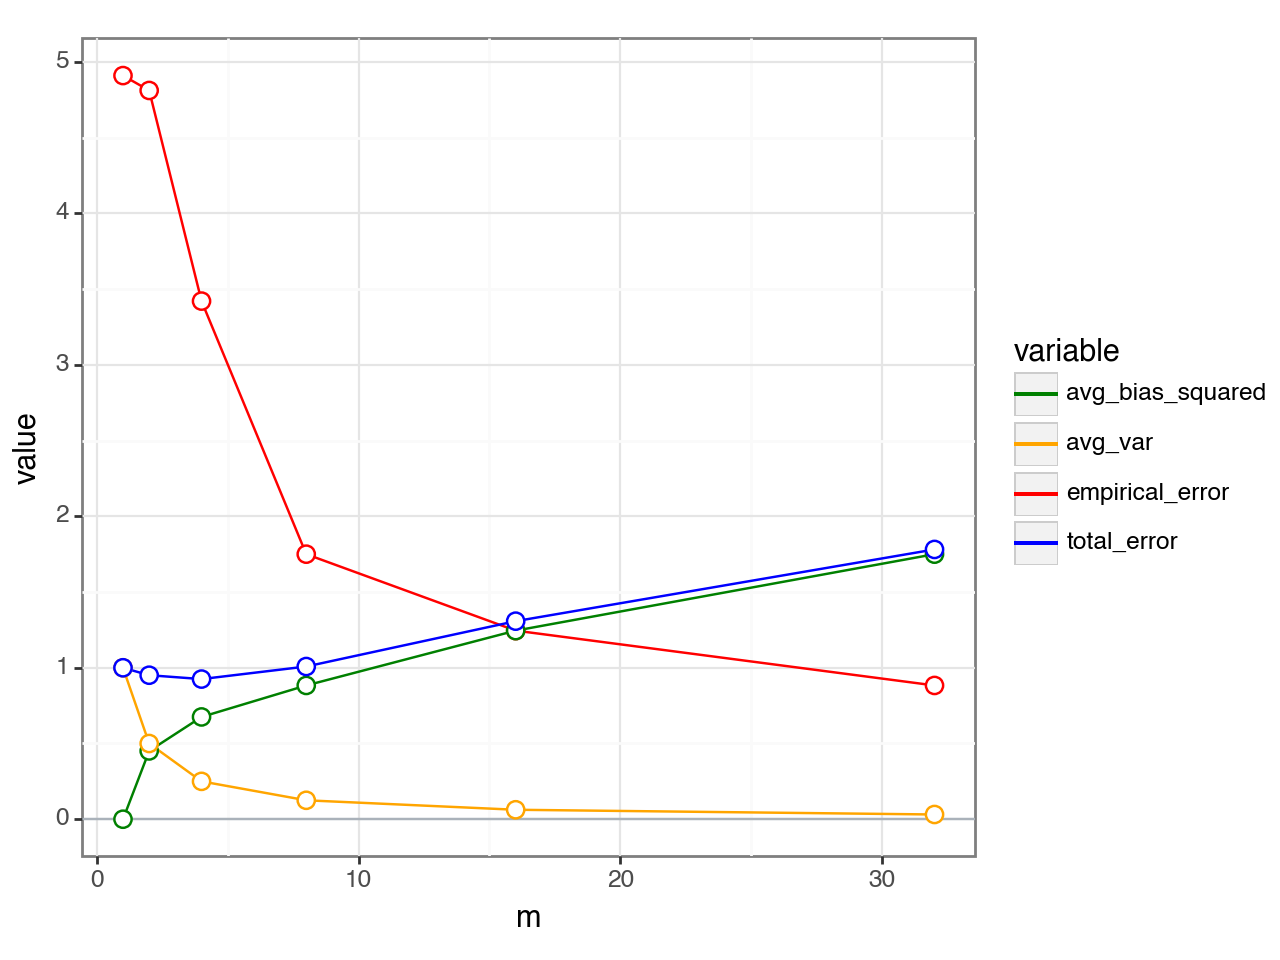

<Figure Size: (640 x 480)>

In [25]:
from plotnine import *
result = results.melt(id_vars='m')

(
    ggplot(result, aes(x='m', y='value')) +
    geom_hline(yintercept=0, color='slategray', alpha=0.5) +
    geom_line(aes(color='variable')) +
    geom_point(aes(color='variable'),
               show_legend=False, fill='white', size=3) +
    scale_color_manual(values=['green', 'orange', 'red', 'blue']) +
    theme_bw()  
)